In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)
file_path = '/content/drive/MyDrive/DATA602FinalProjectRawData/CrashData_for cleaning.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


# EDA and Preparing the Data for Modeling

In [ ]:
df.head()

,OBJECTID,Document Nbr,Crash Year,Crash Date,Crash Military Time,Crash Severity,K_People,A_People,B_People,C_People,...,VSP,Ownership,Planning District,MPO Name,RTE Name,RNS MP,Node,Node Offset (ft),x,y
0,990050,240015077,2024,1/1/2024 5:00:00 AM,240,O,0,0,0,0,...,2,1. State Hwy Agency,George Washington Regional,FRED,R-VA088SC00610EB,9.15,1163185.0,38.45,-77.573248,38.286153
1,990051,240015102,2024,1/1/2024 5:00:00 AM,705,B,0,0,1,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,R-VA SR00168NB,26.50,729349.0,81.54,-76.257527,36.892981
2,990052,240015183,2024,1/1/2024 5:00:00 AM,1345,O,0,0,0,0,...,4,1. State Hwy Agency,Mount Rogers,NaN,R-VA IS00081SB,84.39,NaN,NaN,-80.882202,36.950311
3,990053,240015211,2024,1/1/2024 5:00:00 AM,1847,O,0,0,0,0,...,1,3. City or Town Hwy Agency,Richmond Regional,RICH,S-VA127PR LANGSTON AVE,0.08,NaN,NaN,-77.452005,37.565200
4,990054,240025016,2024,1/1/2024 5:00:00 AM,1845,O,0,0,0,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA US00050WB,69.70,NaN,NaN,-77.339985,38.859288


In [ ]:
import re

def extract_numbers_from_columns(df):
    """
    Processes all columns in a DataFrame, extracting numbers from values
    in the format "number.text" while keeping non-matching values as-is.
    """
    for col in df.columns:
        if df[col].dtype == object:  # Check if column is string/object type
            df[col] = df[col].apply(
                lambda x: (
                    int(re.search(r'^(\d+)\.', str(x)).group(1))  # Convert matched numbers to int
                    if pd.notna(x) and re.search(r'^(\d+)\.', str(x))
                    else x  # Keep original value if no match
                )
            )
    return df

df = extract_numbers_from_columns(df)

In [ ]:
# Finding all columns containing Yes/No values (case insensitive)
yes_no_cols = [col for col in df.columns
               if df[col].astype(str).str.lower().isin(['yes','no','y','n','1','0']).all()
               or col.endswith('?')]

print("Columns to be converted:")
print(yes_no_cols)

Columns to be converted:
['Alcohol?', 'Animal Related?', 'Unrestrained?', 'Bike?', 'Distracted?', 'Drowsy?', 'Drug Related?', 'Guardrail Related?', 'Hitrun?', 'Lgtruck?', 'Motorcycle?', 'Pedestrian?', 'Speed?', 'Senior?', 'Young?', 'Mainline?', 'Night?']


In [ ]:
# Creating a mapping dictionary for all possible variations
binary_map = {
    'YES': 1, 'Yes': 1, 'yes': 1, 'Y': 1, 'y': 1, '1': 1, 'TRUE': 1, 'True': 1, 'true': 1,
    'NO': 0, 'No': 0, 'no': 0, 'N': 0, 'n': 0, '0': 0, 'FALSE': 0, 'False': 0, 'false': 0
}

# Applying to all identified columns
for col in yes_no_cols:
    # Converting to string, striping whitespace, then mapping
    df[col] = (
        df[col].astype(str)
        .str.strip()
        .str.upper()
        .map(binary_map))

    # Ensuring numeric type
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

In [ ]:
#Identifying Missing Values and thier percentages
missing_data = df.isnull().sum().to_frame(name="Missing Values")
missing_data["Missing (%)"] = (missing_data["Missing Values"] / len(df)) * 100
missing_data = missing_data[missing_data["Missing Values"] > 0].sort_values("Missing Values", ascending=False)

display(missing_data)

,Missing Values,Missing (%)
Work Zone Location,134896,97.178218
Work Zone Type,134895,97.177498
Max Speed Diff,111106,80.040054
Node Offset (ft),63729,45.909965
Node,63729,45.909965
MPO Name,31046,22.365340
Facility Type,2284,1.645379
Functional Class,1830,1.318320
RNS MP,629,0.453128
x,35,0.025214


In [ ]:
#Removing unused or high missing value columns from the dataset
df = df.drop(columns=['OBJECTID','RoadDeparture Type', 'Functional Class', 'Intersection Analysis',
                      'Juris Code', 'Facility Type', 'RNS MP', 'RTE Name', 'Work Zone Location', 'Work Zone Type',
                      'SYSTEM', 'Planning District','x', 'y', 'MPO Name', 'Node Offset (ft)', 'Node'])

In [ ]:
#Identifying Missing Values
missing_data = df.isnull().sum().to_frame(name="Missing Values")
missing_data["Missing (%)"] = (missing_data["Missing Values"] / len(df)) * 100
missing_data = missing_data[missing_data["Missing Values"] > 0].sort_values("Missing Values", ascending=False)

display(missing_data)

,Missing Values,Missing (%)
Max Speed Diff,111106,80.040054


In [ ]:
# Adding median imputation for Max Speed Diff
num_cols = ['Max Speed Diff']
def group_median_impute(series, group_col):
    # Only impute NaN values, preserving zeros
    group_medians = df.groupby(group_col)[series.name].median()
    imputed_series = series.fillna(df[series.name].groupby(df[group_col]).transform(lambda x: x.median()).fillna(df[series.name].median()))
    return imputed_series

# Check zeros before imputation
zeros_before = {col: (df[col] == 0).sum() for col in num_cols if col in df.columns}

# Apply group-based median imputation
for col in num_cols:
    if col in df.columns:
        df[col] = group_median_impute(df[col], 'Crash Severity')

# Verify zeros are preserved
zeros_after = {col: (df[col] == 0).sum() for col in num_cols if col in df.columns}
for col in num_cols:
    if col in df.columns:
        assert zeros_before[col] == zeros_after[col], f"Zeros in {col} were altered during imputation"


In [ ]:
#Double Checking Missing Values
missing_data = df.isnull().sum().to_frame(name="Missing Values")
missing_data["Missing (%)"] = (missing_data["Missing Values"] / len(df)) * 100
missing_data = missing_data[missing_data["Missing Values"] > 0].sort_values("Missing Values", ascending=False)

display(missing_data)

,Missing Values,Missing (%)


In [ ]:
# changing Work Zone Related 'Not Applicable' to 0 , School Zone 'Not Applicable' to 0
map_notapplicable = {'Not Applicable': 0}
df['Work Zone Related'] = df['Work Zone Related'].map(map_notapplicable).fillna(0).astype(int)
df['School Zone'] = df['School Zone'].map(map_notapplicable).fillna(0).astype(int)

In [ ]:
# Changing Urban to 1 and Rural to 0 in column Area Type
area_type_map = {'Urban': 1, 'Rural': 0}

# Applying the mapping to the 'Area Type' column
df['Area Type'] = df['Area Type'].map(area_type_map).fillna(0).astype(int)


In [ ]:
df.to_csv("cleaned_To_use.csv", index=False)

In [ ]:
df = pd.read_csv("/content/cleaned_To_use.csv")

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 742.3 kB/s eta 0:00:00


# Modling and Analysis

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, r2_score, accuracy_score, precision_score, recall_score

# Three candidate models from different families
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, eval_metric='mlogloss')
}

# Best model selection base of F1, R^2, Percision, and Recall
best_model_name, best_score, best_model = None, 0, None

print("Model Evaluation Metrics:\n")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    f1 = f1_score(y_val, y_pred, average='weighted')
    r2 = r2_score(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted')

    print(f"{name}:")
    print(f"  F1-weighted score: {f1:.4f}")
    print(f"  R² score: {r2:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print()

    if f1 > best_score:
        best_score, best_model_name, best_model = f1, name, model

print(f"Best model: {best_model_name} with F1-weighted score: {best_score:.4f}")

Model Evaluation Metrics:

LogisticRegression:
  F1-weighted score: 0.4147
  R² score: -2.7331
  Accuracy: 0.3736
  Precision (weighted): 0.6391
  Recall (weighted): 0.3736

RandomForest:
  F1-weighted score: 0.5383
  R² score: -1.8729
  Accuracy: 0.4951
  Precision (weighted): 0.6174
  Recall (weighted): 0.4951

XGBoost:
  F1-weighted score: 0.5105
  R² score: -2.3010
  Accuracy: 0.4553
  Precision (weighted): 0.6180
  Recall (weighted): 0.4553

Best model: RandomForest with F1-weighted score: 0.5383


The RandomForest model emerged as the top performer in our initial model comparison, achieving the highest F1-weighted score (0.5383), ahead of XGBoost (0.5105) and Logistic Regression (0.4147). This performance metric is well-suited to our imbalanced multiclass classification task, predicting crash severity, because it balances precision and recall while weighting results by class frequency. RandomForest was a strong candidate because it captures non-linear interactions among features, handles feature collinearity well, and includes mechanisms (like max depth and ensemble averaging) to reduce overfitting.

However, for the final model, we transitioned to using the BalancedRandomForestClassifier. While it is built on the RandomForest architecture, it enhances standard RandomForest by integrating internal data resampling to address class imbalance more effectively. This is particularly important in our context, where the "High" severity class is underrepresented. Traditional RandomForest can bias predictions toward majority classes despite using class_weight='balanced'. In contrast, BalancedRandomForestClassifier from the imblearn library performs bootstrapped sampling from each class to ensure equal representation during training, improving minority class recall without requiring external oversampling techniques.

Thus, even though the standard RandomForest scored highest during model selection, BalancedRandomForestClassifier offers a more robust and fair final model for deployment, aligning better with our goal of maintaining predictive validity across all severity levels.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

# organizing data by date for future adjustment (no sampling)
df['Crash Date'] = pd.to_datetime(df['Crash Date'], errors='coerce')
df = df[(df['Crash Date'] >= '2024-01-01') & (df['Crash Date'] <= '2025-04-28')].copy()
df['Crash Severity'] = df['Crash Severity'].map({'O': 0, 'C': 0.3, 'B': 0.5, 'A': 0.7, 'K': 1.0})
bins = [-0.1, 0.3, 0.7, 1.0]
labels = ['Low', 'Medium', 'High']
df['Crash Severity Class'] = pd.cut(df['Crash Severity'], bins=bins, labels=labels, include_lowest=True)
print(f"Full dataset size: {df.shape[0]} rows")

# Feature engineering
def engineer_features(df):
    df['High_Impact_Collision'] = df['Collision Type'].isin([2, 6]).astype('int8')
    df['Vulnerable_Users'] = ((df['Pedestrian?'] == 1) | (df['Motorcycle?'] == 1) | (df['Bike?'] == 1)).astype('int8')
    df['Impaired_Driver'] = ((df['Alcohol?'] == 1) | (df['Drug Related?'] == 1)).astype('int8')
    df['Speed_Distracted'] = ((df['Speed?'] == 1) & (df['Distracted?'] == 1)).astype('int8')
    df['Unrestrained_Risk'] = (df['Unrestrained?'] == 1).astype('int8')
    weather_hazard_map = {1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 1, 8: 0}
    df['Weather_Hazard'] = df['Weather Condition'].map(weather_hazard_map).fillna(0).astype('int8')
    road_surface_hazard_map = {1: 0, 2: 1, 3: 1, 4: 2, 5: 2}
    df['Road_Surface_Hazard'] = df['Roadway Surface Condition'].map(road_surface_hazard_map).fillna(0).astype('int8')
    light_hazard_map = {1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 0}
    df['Light_Hazard'] = df['Light Condition'].map(light_hazard_map).fillna(0).astype('int8')
    df['Crash_Hour'] = df['Crash Military Time'].apply(lambda x: int(str(x).zfill(4)[:2]) if pd.notnull(x) else 12).astype('int8')
    df['Crash Date'] = pd.to_datetime(df['Crash Date'], errors='coerce')
    df['Is_Weekend'] = df['Crash Date'].dt.weekday.isin([5, 6]).astype('int8')
    df['Is_Rush_Hour'] = df['Crash_Hour'].isin([7, 8, 9, 16, 17, 18]).astype('int8')
    df['Speed_Difficulty'] = df['Max Speed Diff'].apply(lambda x: 1 if x > 10 else 0).astype('int8')
    df['High_Impact_Impaired'] = (df['High_Impact_Collision'] * df['Impaired_Driver']).astype('int8')
    return df

df = engineer_features(df)

# Defining features
features = [
    'Collision Type', 'Vehicle Count', 'Vulnerable_Users', 'Impaired_Driver',
    'Unrestrained_Risk', 'Weather_Hazard', 'Road_Surface_Hazard', 'Light_Hazard',
    'Crash_Hour', 'Is_Weekend', 'Is_Rush_Hour', 'Speed_Difficulty', 'Vulnerable_Night',
    'Roadway Description', 'VDOT District'
]
features = [f for f in features if f in df.columns]

# Handling multicollinearity
numerical_features = ['Vehicle Count', 'Crash_Hour']
corr_matrix = df[numerical_features].corr()
print("Correlation Matrix for Numerical Features:\n", corr_matrix)

# Subsampling to address class imbalance
df_high = df[df['Crash Severity Class'] == 'High']
df_medium = df[df['Crash Severity Class'] == 'Medium'].sample(n=min(10000, len(df[df['Crash Severity Class'] == 'Medium'])), random_state=42)
df_low = df[df['Crash Severity Class'] == 'Low'].sample(n=20000, random_state=42)
df_balanced = pd.concat([df_high, df_medium, df_low]).reset_index(drop=True)

# Handling high cardinality
def group_rare_categories(df, column, threshold=0.01):
    value_counts = df[column].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index
    df[column + '_grouped'] = df[column].where(~df[column].isin(rare_categories), 'Other')
    return df

categorical_cols = ['Collision Type', 'Roadway Description', 'VDOT District']
for col in categorical_cols:
    if col in df_balanced.columns:
        df_balanced = group_rare_categories(df_balanced, col, threshold=0.01)

# Updating features
features = [f + '_grouped' if f in categorical_cols else f for f in features]
features = [f for f in features if f in df_balanced.columns]
df_balanced = df_balanced.dropna(subset=features + ['Crash Severity Class'])

# Spliting data by into 60% Traning, 15% Validation, and 25% Test
X = df_balanced[features]
y = df_balanced['Crash Severity Class']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Target encoding
target_encoder = TargetEncoder(cols=[f for f in features if f.endswith('_grouped')])
X_train_encoded = target_encoder.fit_transform(X_train, y_train.map({'Low': 0, 'Medium': 0.5, 'High': 1}))
X_val_encoded = target_encoder.transform(X_val)
X_test_encoded = target_encoder.transform(X_test)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Applying SMOTE
smote = SMOTE(sampling_strategy={'High': int(1.0 * len(y_train[y_train == 'Low'])), 'Medium': int(0.75 * len(y_train[y_train == 'Low']))}, random_state=42, k_neighbors=3)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
if len(X_train_scaled) > 30000:
    indices = np.random.choice(len(X_train_scaled), 30000, replace=False)
    X_train_scaled, y_train = X_train_scaled[indices], y_train[indices]
print(f"Training set size after SMOTE: {X_train_scaled.shape[0]} rows")

# Training model
class_weights = {'Low': 1, 'Medium': 1, 'High': 2}
model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight=class_weights, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='f1_weighted')
print("\nCross-Validation F1-Weighted Scores:", cv_scores)
print("Mean CV F1-Weighted Score:", cv_scores.mean())

# Evaluation and printing results
y_val_pred = model.predict(X_val_scaled)
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

y_test_pred = model.predict(X_test_scaled)
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Threshold tuning and printing results
y_scores = model.predict_proba(X_val_scaled)[:, model.classes_.tolist().index('High')]
precision, recall, thresholds = precision_recall_curve((y_val == 'High').astype(int), y_scores)
thresholds = np.append(thresholds, 1.0)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
valid_indices = (recall > 0.7) & (precision > 0.05)
optimal_threshold = thresholds[valid_indices][np.argmax(f1_scores[valid_indices])] if np.any(valid_indices) else 0.5
print(f"Optimal threshold for High class (recall > 0.7, precision > 0.05): {optimal_threshold:.3f}")
y_val_pred_threshold = (model.predict_proba(X_val_scaled)[:, model.classes_.tolist().index('High')] >= optimal_threshold).astype(int)
print("\nValidation Set (High Class) with Adjusted Threshold:")
print(classification_report((y_val == 'High').astype(int), y_val_pred_threshold))

# Feature importance and displaying rsult
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importances:\n", feature_importance)

# Save results
with open('analysis_results.txt', 'w') as f:
    f.write("Class Distribution:\n" + df_balanced['Crash Severity Class'].value_counts().to_string() + "\n\n")
    f.write("Cross-Validation F1-Weighted Scores:\n" + str(cv_scores) + "\nMean: " + str(cv_scores.mean()) + "\n\n")
    f.write("Validation Set Classification Report:\n" + classification_report(y_val, y_val_pred, output_dict=False) + "\n")
    f.write("Test Set Classification Report:\n" + classification_report(y_test, y_test_pred, output_dict=False) + "\n")
    f.write("Validation Set (High Class) with Adjusted Threshold:\n" + classification_report((y_val == 'High').astype(int), y_val_pred_threshold, output_dict=False) + "\n")
    f.write("Feature Importances:\n" + feature_importance.to_string() + "\n")

Full dataset size: 138813 rows
Correlation Matrix for Numerical Features:
                Vehicle Count  Crash_Hour
Vehicle Count        1.00000     0.06999
Crash_Hour           0.06999     1.00000
Training set size after SMOTE: 30000 rows

Cross-Validation F1-Weighted Scores: [0.72330747 0.72142401 0.72182737]
Mean CV F1-Weighted Score: 0.7221862824955423

Validation Set Classification Report:
              precision    recall  f1-score   support

        High       0.22      0.80      0.35       138
         Low       0.75      0.81      0.78      3001
      Medium       0.48      0.29      0.36      1500

    accuracy                           0.64      4639
   macro avg       0.48      0.63      0.50      4639
weighted avg       0.65      0.64      0.63      4639


Test Set Classification Report:
              precision    recall  f1-score   support

        High       0.21      0.74      0.33       231
         Low       0.75      0.81      0.78      5000
      Medium       0.48  

<ipython-input-315-fd7b9567e0ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


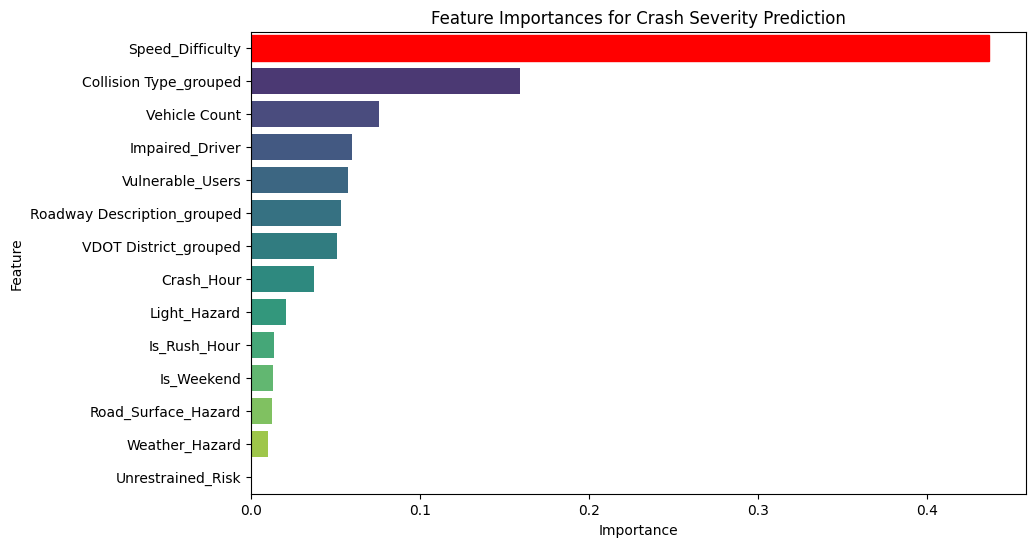

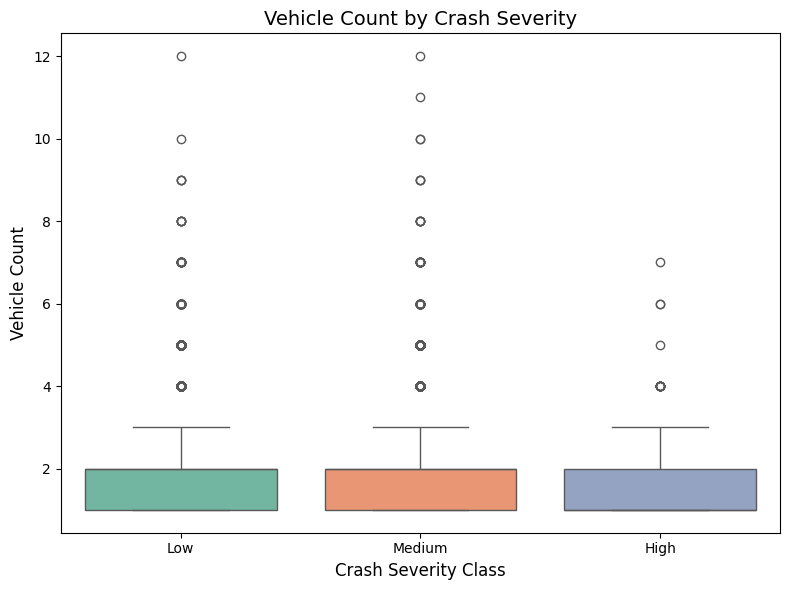

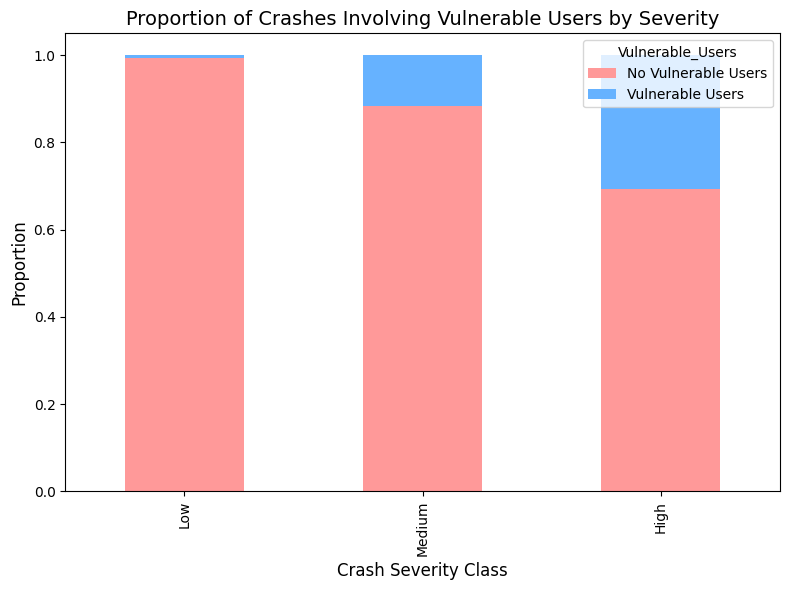

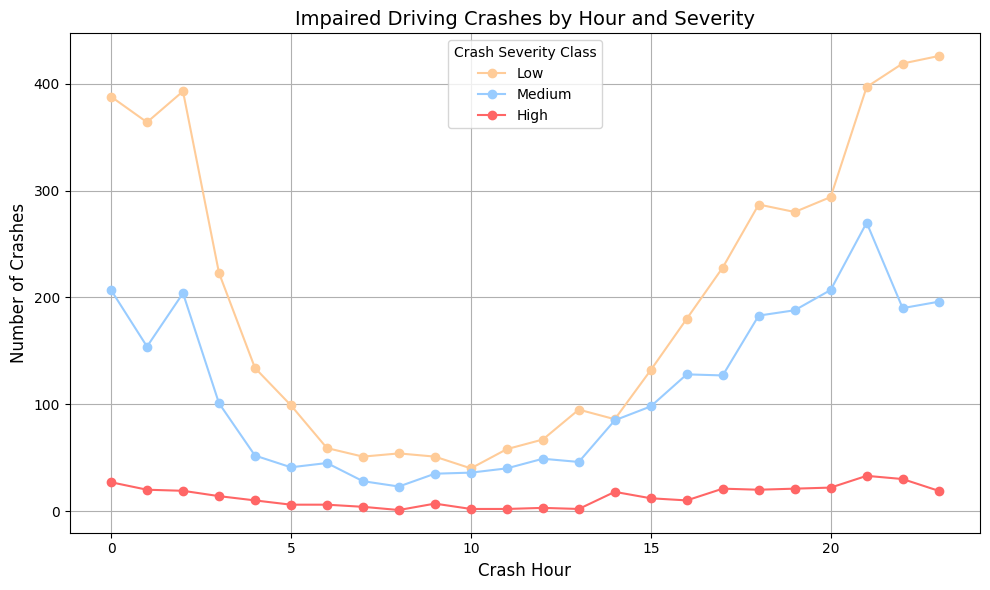

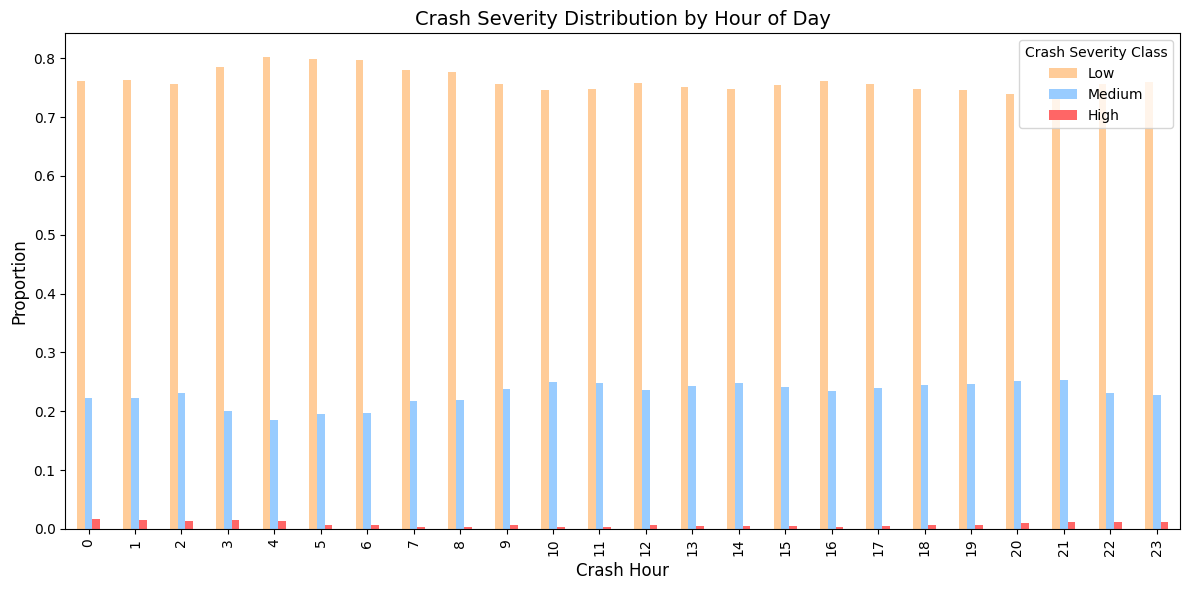

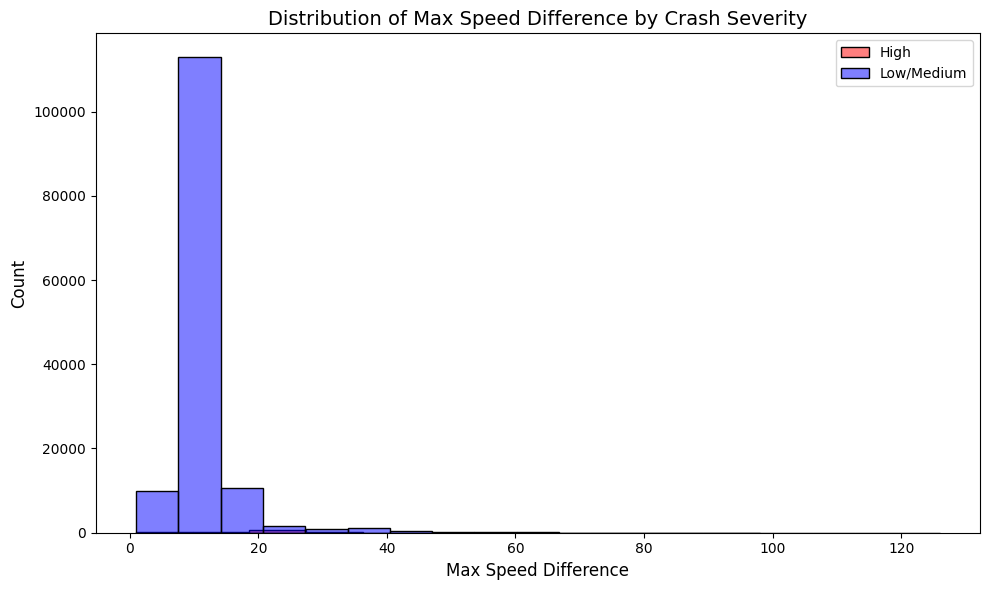

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature_importance' DataFrame from the previous code
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importances for Crash Severity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')

# 1. Highlight 'Collision Type'
collision_type_col = 'Collision Type_grouped' if 'Collision Type_grouped' in feature_importance['feature'].values else 'Collision Type'
collision_type_index = feature_importance[feature_importance['feature'] == collision_type_col].index[0]
plt.gca().get_children()[collision_type_index].set_color('red')

plt.show()

# 2. Vehicle Count by Severity
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crash Severity Class', y='Vehicle Count', hue='Crash Severity Class', data=df, palette='Set2', order=['Low', 'Medium', 'High'], legend=False)
plt.title('Vehicle Count by Crash Severity', fontsize=14)
plt.xlabel('Crash Severity Class', fontsize=12)
plt.ylabel('Vehicle Count', fontsize=12)
plt.tight_layout()
plt.savefig('vehicle_count_by_severity.png')
plt.show()

# 3. Vulnerable Users by Severity
vuln_counts = df.groupby(['Crash Severity Class', 'Vulnerable_Users'], observed=False).size().unstack().fillna(0)
vuln_counts = vuln_counts.div(vuln_counts.sum(axis=1), axis=0)
vuln_counts.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#FF9999', '#66B2FF'])
plt.title('Proportion of Crashes Involving Vulnerable Users by Severity', fontsize=14)
plt.xlabel('Crash Severity Class', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(['No Vulnerable Users', 'Vulnerable Users'], title='Vulnerable_Users')
plt.tight_layout()
plt.savefig('vulnerable_users_by_severity.png')
plt.show()

# 4. Severity by Roadway Type (if available)
if 'Roadway Description_grouped' in df.columns:
    roadway_severity = df.groupby(['Roadway Description_grouped', 'Crash Severity Class'], observed=False).size().unstack().fillna(0)
    roadway_severity = roadway_severity.div(roadway_severity.sum(axis=1), axis=0)
    roadway_severity.plot(kind='bar', figsize=(10, 6), color=['#FFCC99', '#99CCFF', '#FF6666'])
    plt.title('Crash Severity Distribution by Roadway Type', fontsize=14)
    plt.xlabel('Roadway Description', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.legend(title='Crash Severity Class')
    plt.tight_layout()
    plt.savefig('severity_by_roadway_type.png')
    plt.show()

# 5. Impaired Driving by Hour
impaired_by_hour = df[df['Impaired_Driver'] == 1].groupby(['Crash_Hour', 'Crash Severity Class'], observed=False).size().unstack().fillna(0)
impaired_by_hour.plot(kind='line', figsize=(10, 6), marker='o', color=['#FFCC99', '#99CCFF', '#FF6666'])
plt.title('Impaired Driving Crashes by Hour and Severity', fontsize=14)
plt.xlabel('Crash Hour', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.legend(title='Crash Severity Class')
plt.grid(True)
plt.tight_layout()
plt.savefig('impaired_driving_by_hour.png')
plt.show()

# 6. Severity by VDOT District (if available)
if 'VDOT District_grouped' in df.columns:
    district_severity = df.groupby(['VDOT District_grouped', 'Crash Severity Class'], observed=False).size().unstack().fillna(0)
    district_severity = district_severity.div(district_severity.sum(axis=1), axis=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(district_severity, annot=True, cmap='Reds', fmt='.2f')
    plt.title('Crash Severity Proportion by VDOT District', fontsize=14)
    plt.xlabel('Crash Severity Class', fontsize=12)
    plt.ylabel('VDOT District', fontsize=12)
    plt.tight_layout()
    plt.savefig('severity_by_vdot_district.png')
    plt.show()

# 7. Severity by Crash Hour
hour_severity = df.groupby(['Crash_Hour', 'Crash Severity Class'], observed=False).size().unstack().fillna(0)
hour_severity = hour_severity.div(hour_severity.sum(axis=1), axis=0)
hour_severity.plot(kind='bar', figsize=(12, 6), color=['#FFCC99', '#99CCFF', '#FF6666'])
plt.title('Crash Severity Distribution by Hour of Day', fontsize=14)
plt.xlabel('Crash Hour', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Crash Severity Class')
plt.tight_layout()
plt.savefig('severity_by_crash_hour.png')
plt.show()

# 8. Speed Difference by Severity
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['Crash Severity Class'] == 'High'], x='Max Speed Diff', color='red', label='High', alpha=0.5)
sns.histplot(data=df[df['Crash Severity Class'] != 'High'], x='Max Speed Diff', color='blue', label='Low/Medium', alpha=0.5)
plt.title('Distribution of Max Speed Difference by Crash Severity', fontsize=14)
plt.xlabel('Max Speed Difference', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('speed_diff_by_severity.png')
plt.show()